
# KDD Cup 1999 - Anomali Tespiti

Bu defter, KDD Cup 1999 veri seti üzerinde **anomali (saldırı) tespiti** için uçtan uca bir akış sunar:
1. **Veri Yükleme** (CSV)
2. **Ön İşleme** (One-Hot + Standardizasyon, Train/Test)
3. **Modeller**: Lojistik Regresyon, Random Forest, Decision Tree, Lineer (SGDClassifier), *(opsiyonel)* XGBoost
4. **Hiperparametre Optimizasyonu** (GridSearchCV)
5. **Değerlendirme** (ROC-AUC, PR-Eğrisi, F1, Confusion Matrix)
6. **PCA(2)** üzerinde **karar sınırı** görselleştirme (SVM ile)
7. **K-Means**: Elbow (WCSS) + **Silhouette** skoru
8. **SelectKBest (ANOVA F)** ile örnek **özellik seçimi**

> Bu çalışma **sınıflandırma** problemidir (Normal vs Attack).



In [78]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, f1_score, confusion_matrix,
    classification_report
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif

import joblib

plt.rcParams['figure.figsize'] = (8, 6)
RANDOM_STATE = 42



## I. Veri Setinin Yüklenmesi

Bu bölümde **KDD Cup 1999** veri seti `pandas` ile CSV'den okunur.  
Etiket sütunu (`label`) **ikili** hale getirilir: `normal` → 0, diğer saldırılar → 1.


In [79]:

# CSV dosya yolu
DATA_PATH = "kdd99.csv"

# KDD 1999 özellik isimleri (41 + label)
KDD_COLUMNS = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
    "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label"
]

assert os.path.exists(DATA_PATH), f"Bulunamadı: {DATA_PATH}"

def load_kdd(DATA_PATH):
    # 1) Önce dosyayı "başlıksız" varsayarak oku
    df_try = pd.read_csv(DATA_PATH, header=None, names=KDD_COLUMNS, low_memory=False)
    # Eğer ilk satır "duration" ise, demek ki dosyada zaten başlık var -> yeniden oku
    if isinstance(df_try.iloc[0, 0], str) and df_try.iloc[0, 0].strip().lower() == "duration":
        df = pd.read_csv(DATA_PATH, header=0, names=KDD_COLUMNS, low_memory=False)
    else:
        df = df_try
    return df

df = load_kdd(DATA_PATH)

# Güvenlik: sayısal olması gereken sütunları coercion ile numeriğe çevir
categorical_cols = ['protocol_type', 'service', 'flag', 'label']  # bunlar kategorik
numeric_candidates = [c for c in KDD_COLUMNS if c not in categorical_cols]
for c in numeric_candidates:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# (Varsa) tamamen boş kalan satırları at
df = df.dropna(subset=['duration', 'src_bytes', 'dst_bytes'])

# Binary etiket
df['label_binary'] = np.where(df['label'].astype(str).str.contains('normal'), 0, 1)

# === Alt örnekleme (hızlı çalıştırma için) ===
# 50k satırlık örneklem kullanılmıştır.

df = df.sample(50_000, random_state=42).reset_index(drop=True)

print("Alt örneklem boyutu:", df.shape)
print("Saldırı oranı (1):", round(df['label_binary'].mean(), 4))


print("Veri şekli:", df.shape)
print("Saldırı oranı (1):", round(df['label_binary'].mean(), 4))
df.head()


Alt örneklem boyutu: (50000, 43)
Saldırı oranı (1): 0.8034
Veri şekli: (50000, 43)
Saldırı oranı (1): 0.8034


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,label_binary
0,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf,1
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf,1
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.08,0.00,0.00,1.0,1.0,0.0,0.0,neptune,1
3,0,tcp,http,SF,345,5419,0,0,0,0,...,1.00,0.00,0.01,0.02,0.0,0.0,0.0,0.0,normal,0
4,0,tcp,private,S0,0,0,0,0,0,0,...,0.01,0.07,0.00,0.00,1.0,1.0,0.0,0.0,neptune,1


*italik metin*
## II. Veri Ön İşleme

- Kategorik: `protocol_type`, `service`, `flag` → **One-Hot Encoding**  
- Sayısal: Diğer tüm sütunlar → **StandardScaler**  
- **Stratified** train/test bölme (sınıf oranını korur)


In [80]:

categorical_cols = ['protocol_type', 'service', 'flag']
numeric_cols = [c for c in df.columns if c not in categorical_cols + ['label', 'label_binary']]

X = df[categorical_cols + numeric_cols]
y = df['label_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(with_mean=False), numeric_cols)
    ]
)

# Dengesizlik için ölçek önerisi (XGBoost'ta kullanılacak)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight_val = float(neg) / float(pos) if pos > 0 else 1.0
print("scale_pos_weight önerisi:", round(scale_pos_weight_val, 2))


scale_pos_weight önerisi: 0.24


## Aykırı Veri Noktaları ve Anomalilerin Görselleştirilmesi


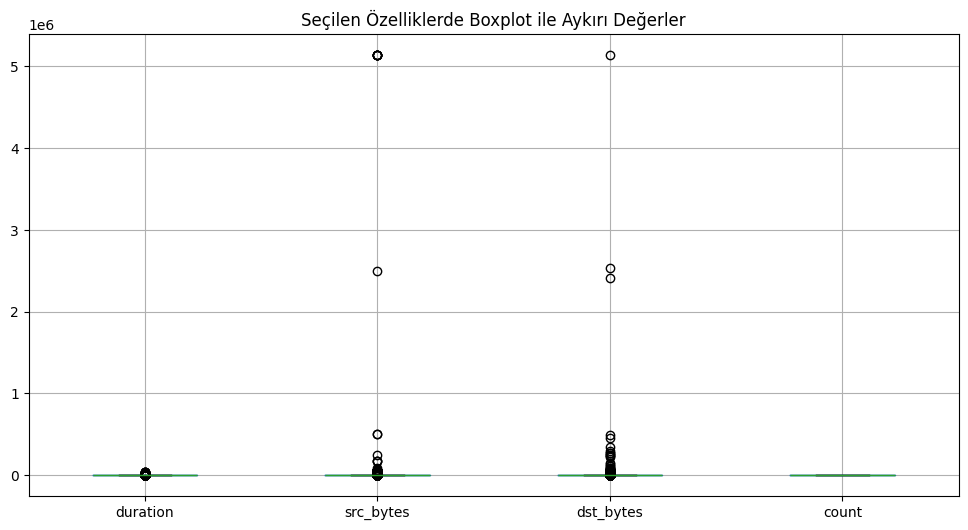

Toplam gözlem sayısı: 50000
Aykırı gözlem sayısı (|z|>3): 409
Aykırı gözlem oranı: 0.82%


In [81]:
import seaborn as sns
from scipy import stats

# Sayısal sütunlardan birkaçını seçelim
num_cols_sample = ['duration', 'src_bytes', 'dst_bytes', 'count']

# Boxplot görselleştirme
plt.figure(figsize=(12,6))
df[num_cols_sample].boxplot()
plt.title("Seçilen Özelliklerde Boxplot ile Aykırı Değerler")
plt.show()

# Z-score ile outlier sayısı
z_scores = np.abs(stats.zscore(df[num_cols_sample]))
outlier_mask = (z_scores > 3)
outliers = (outlier_mask.sum(axis=1) > 0).sum()

print(f"Toplam gözlem sayısı: {len(df)}")
print(f"Aykırı gözlem sayısı (|z|>3): {outliers}")
print(f"Aykırı gözlem oranı: {outliers/len(df):.2%}")


Veri setinde aykırı değer analizi yapılmış, Boxplot grafiklerinde özellikle src_bytes ve dst_bytes değişkenlerinde uç noktaların yoğun olduğu görülmüştür. Z-Score yöntemiyle (|z| > 3) yapılan incelemede 50.000 gözlemden 409’unun aykırı değer olduğu belirlenmiş, bu da toplam verinin yaklaşık %0,82’sine karşılık gelmektedir. Bu durum, saldırı trafiğinin tipik özelliği olan aşırı değerlerin veri setinde mevcut olduğunu göstermektedir.



## III. Modeller

Aşağıdaki klasik algoritmalar bir **Pipeline** içinde eğitilecektir:
- **Lojistik Regresyon** (baseline)
- **Random Forest**
- **Decision Tree**
- **SGDClassifier** (lineer, `loss='log_loss'`)  
- **XGBoost**


In [69]:

logreg_pipe = Pipeline([("prep", preprocess),
                        ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])

rf_pipe = Pipeline([("prep", preprocess),
                    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])

dt_pipe = Pipeline([("prep", preprocess),
                    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))])

sgd_pipe = Pipeline([("prep", preprocess),
                     ("clf", SGDClassifier(loss="log_loss", class_weight="balanced", random_state=RANDOM_STATE))])



## IV. Hiperparametre Optimizasyonu (GridSearchCV)

Her model için **ROC-AUC** puanını maksimize edecek şekilde arama yapılır.


In [70]:

search_spaces = {
    "Logistic Regression": (logreg_pipe, {
        "clf__C": [0.1, 1.0, 3.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear"]
    }),
    "Random Forest": (rf_pipe, {
        "clf__n_estimators": [100,200],
        "clf__max_depth": [None, 20],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2]
    }),
    "Decision Tree": (dt_pipe, {
        "clf__max_depth": [None, 10, 20, 40],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__class_weight": [None, "balanced"]
    }),
    "SGD (Linear)": (sgd_pipe, {
        "clf__alpha": [1e-4, 1e-3, 1e-2],
        "clf__max_iter": [1000, 2000],
        "clf__tol": [1e-3, 1e-4]
    })
}


best_models = {}
cv_results = []

for name, (pipe, grid) in search_spaces.items():
    print(f"\n>> {name} GridSearch başlıyor...")
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    cv_results.append((name, gs.best_score_, gs.best_params_))
    print(f"{name} en iyi ROC-AUC (CV): {gs.best_score_:.4f}")
    print(f"{name} en iyi parametreler: {gs.best_params_}")

cv_summary = pd.DataFrame(cv_results, columns=["Model", "ROC-AUC (CV)", "Best Params"]).sort_values("ROC-AUC (CV)", ascending=False)
cv_summary



>> Logistic Regression GridSearch başlıyor...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Logistic Regression en iyi ROC-AUC (CV): 0.9997
Logistic Regression en iyi parametreler: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

>> Random Forest GridSearch başlıyor...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest en iyi ROC-AUC (CV): 1.0000
Random Forest en iyi parametreler: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

>> Decision Tree GridSearch başlıyor...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Decision Tree en iyi ROC-AUC (CV): 0.9993
Decision Tree en iyi parametreler: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}

>> SGD (Linear) GridSearch başlıyor...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SGD (Linear) en iyi ROC-AUC (CV): 0.9994
SGD (Linear) en i

,Model,ROC-AUC (CV),Best Params
1,Random Forest,0.999996,"{'clf__max_depth': None, 'clf__min_samples_lea..."
0,Logistic Regression,0.999704,"{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so..."
3,SGD (Linear),0.999386,"{'clf__alpha': 0.0001, 'clf__max_iter': 1000, ..."
2,Decision Tree,0.999281,"{'clf__class_weight': 'balanced', 'clf__max_de..."



## V. Model Değerlendirme

Her model için test setinde:
- **ROC-AUC**, **PR-AUC**, **F1** skorları
- **ROC** ve **Precision-Recall** eğrileri
- **Karmaşıklık Matrisi (Confusion Matrix)**



[Logistic Regression]
ROC-AUC  (train/test): 0.9998 / 0.9998
PR-AUC   (train/test): 0.9999 / 1.0
F1-score (train/test): 0.999 / 0.9988

Classification Report (Test):
               precision    recall  f1-score   support

           0     0.9934    0.9964    0.9949      1966
           1     0.9991    0.9984    0.9988      8034

    accuracy                         0.9980     10000
   macro avg     0.9963    0.9974    0.9968     10000
weighted avg     0.9980    0.9980    0.9980     10000



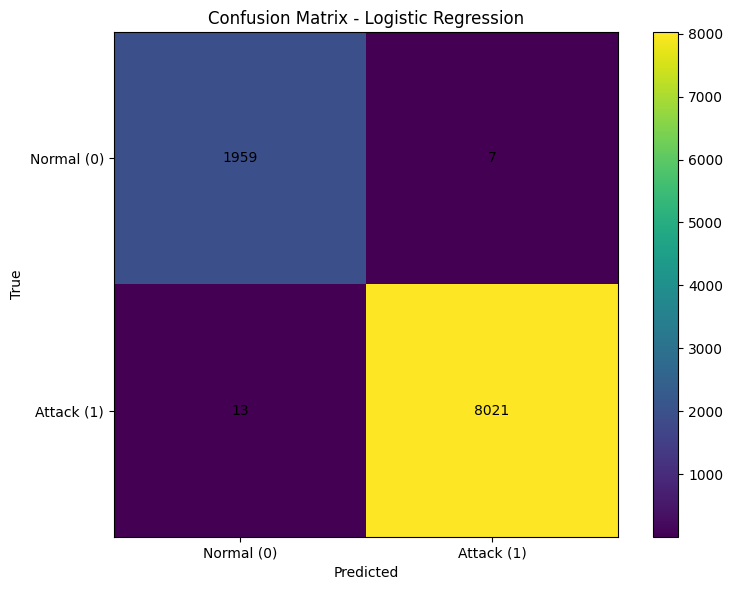

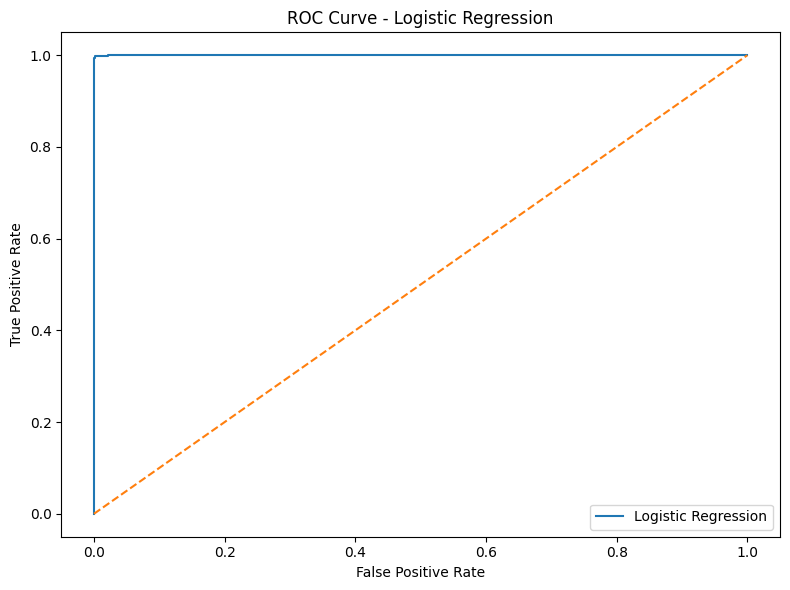

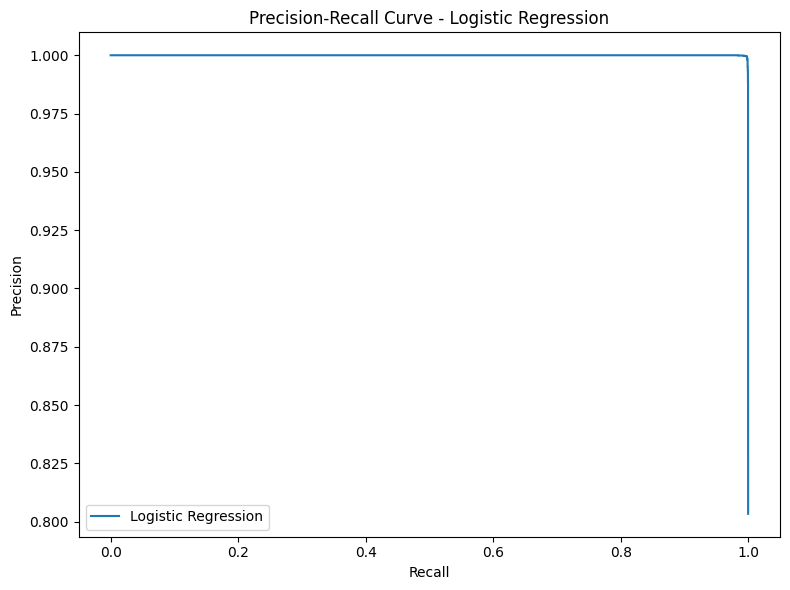


[Random Forest]
ROC-AUC  (train/test): 1.0 / 1.0
PR-AUC   (train/test): 1.0 / 1.0
F1-score (train/test): 1.0 / 0.9995

Classification Report (Test):
               precision    recall  f1-score   support

           0     0.9959    1.0000    0.9980      1966
           1     1.0000    0.9990    0.9995      8034

    accuracy                         0.9992     10000
   macro avg     0.9980    0.9995    0.9987     10000
weighted avg     0.9992    0.9992    0.9992     10000



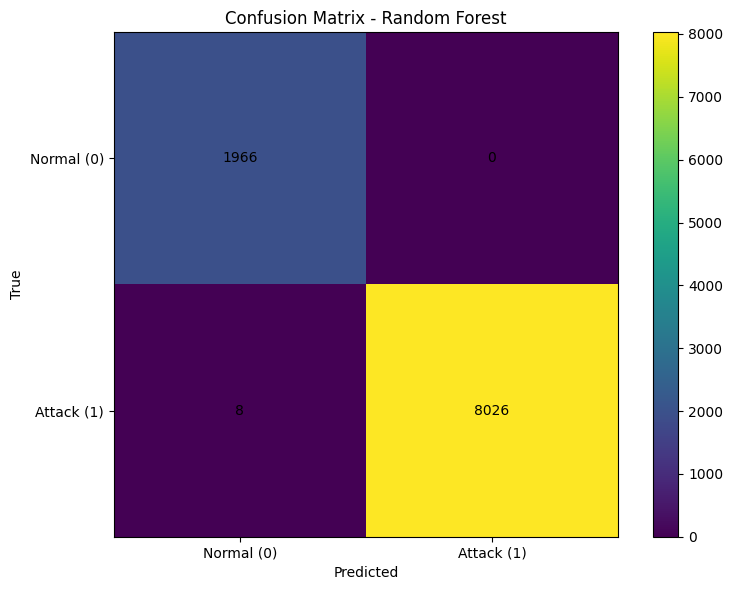

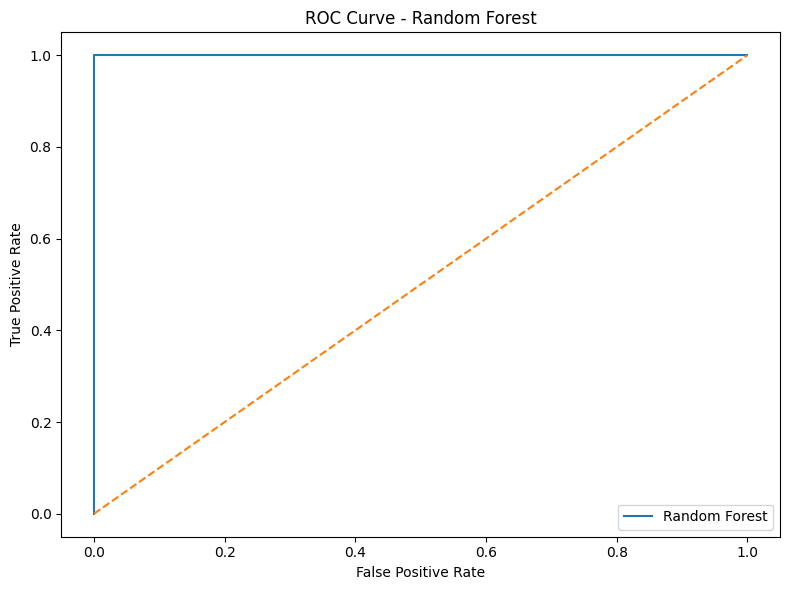

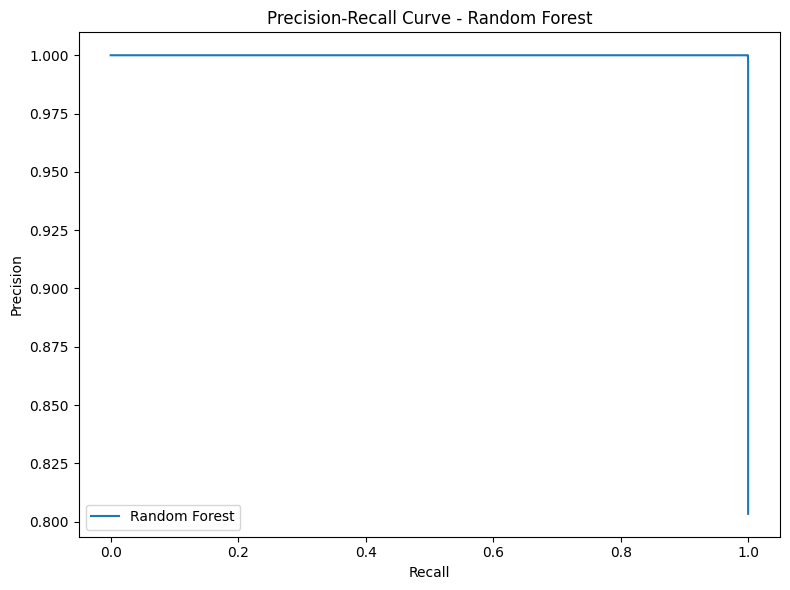


[Decision Tree]
ROC-AUC  (train/test): 1.0 / 0.999
PR-AUC   (train/test): 1.0 / 0.9995
F1-score (train/test): 0.9993 / 0.9986

Classification Report (Test):
               precision    recall  f1-score   support

           0     0.9904    0.9985    0.9944      1966
           1     0.9996    0.9976    0.9986      8034

    accuracy                         0.9978     10000
   macro avg     0.9950    0.9981    0.9965     10000
weighted avg     0.9978    0.9978    0.9978     10000



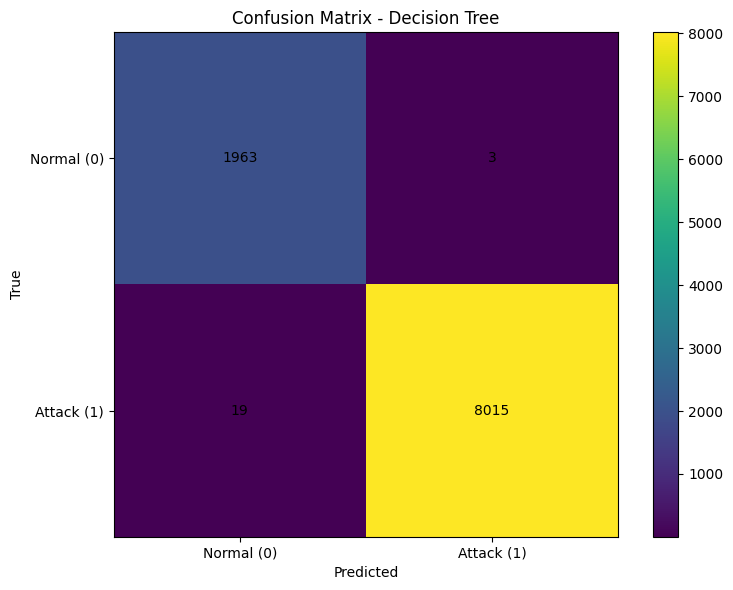

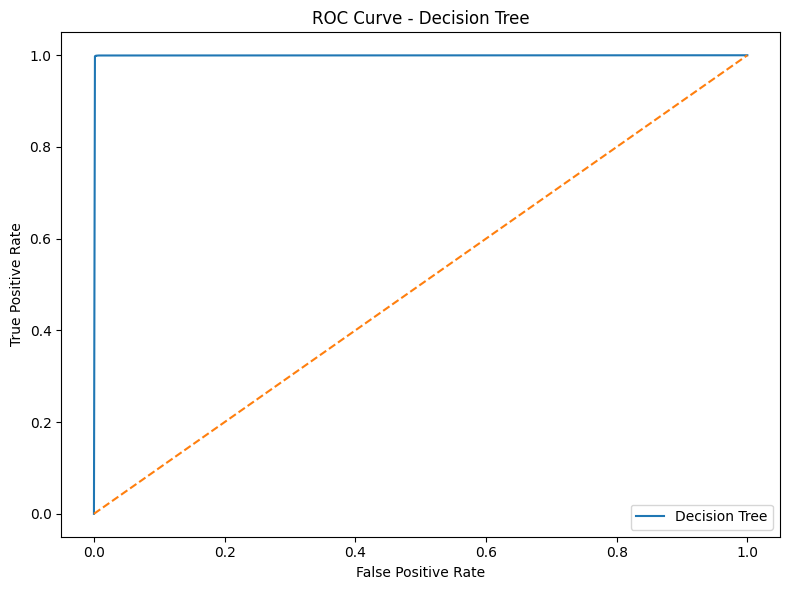

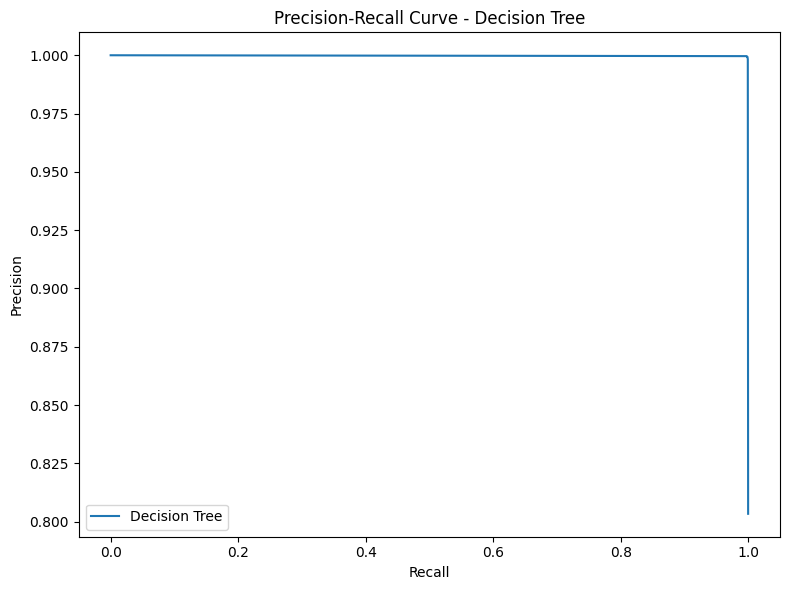


[SGD (Linear)]
ROC-AUC  (train/test): 0.9993 / 0.9996
PR-AUC   (train/test): 0.9998 / 0.9999
F1-score (train/test): 0.9981 / 0.9976

Classification Report (Test):
               precision    recall  f1-score   support

           0     0.9839    0.9964    0.9901      1966
           1     0.9991    0.9960    0.9976      8034

    accuracy                         0.9961     10000
   macro avg     0.9915    0.9962    0.9939     10000
weighted avg     0.9961    0.9961    0.9961     10000



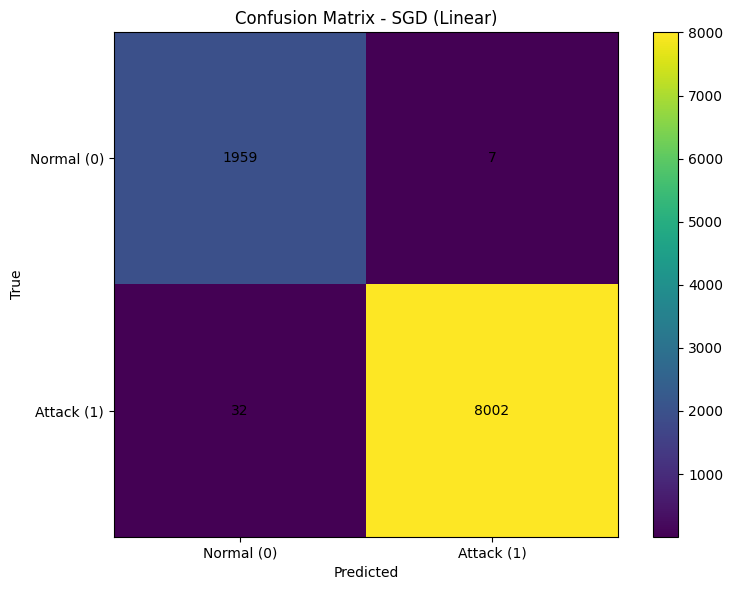

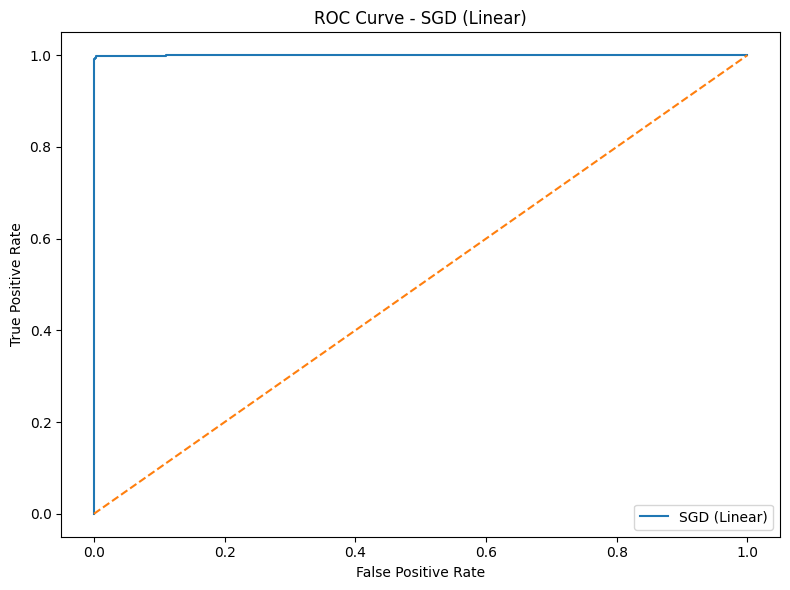

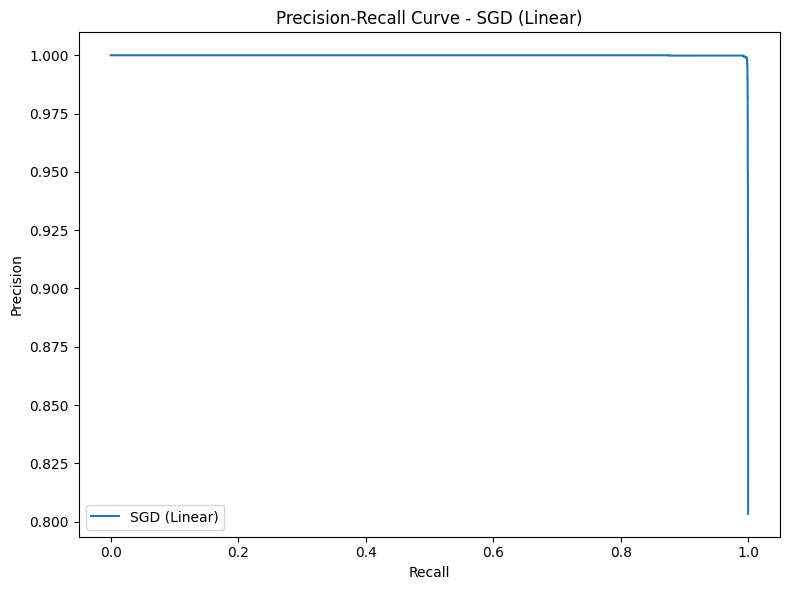

In [71]:

def evaluate_classifier(name, model, X_tr, y_tr, X_te, y_te):
    # Olasılıklar
    y_tr_proba = model.predict_proba(X_tr)[:, 1]
    y_te_proba = model.predict_proba(X_te)[:, 1]

    # 0.5 eşik ile sınıflar
    y_tr_pred = (y_tr_proba >= 0.5).astype(int)
    y_te_pred = (y_te_proba >= 0.5).astype(int)

    # Skorlar
    roc_auc_tr = roc_auc_score(y_tr, y_tr_proba)
    roc_auc_te = roc_auc_score(y_te, y_te_proba)
    ap_tr = average_precision_score(y_tr, y_tr_proba)
    ap_te = average_precision_score(y_te, y_te_proba)
    f1_tr = f1_score(y_tr, y_tr_pred)
    f1_te = f1_score(y_te, y_te_pred)

    print(f"\n[{name}]")
    print("ROC-AUC  (train/test):", round(roc_auc_tr,4), "/", round(roc_auc_te,4))
    print("PR-AUC   (train/test):", round(ap_tr,4), "/", round(ap_te,4))
    print("F1-score (train/test):", round(f1_tr,4), "/", round(f1_te,4))
    print("\nClassification Report (Test):\n", classification_report(y_te, y_te_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_te_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0,1], ['Normal (0)', 'Attack (1)'])
    plt.yticks([0,1], ['Normal (0)', 'Attack (1)'])
    plt.xlabel('Predicted'); plt.ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.tight_layout(); plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_te, y_te_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name}')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}'); plt.legend(); plt.tight_layout(); plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_te, y_te_proba)
    plt.figure()
    plt.plot(rec, prec, label=f'{name}')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}'); plt.legend(); plt.tight_layout(); plt.show()

for name, model in best_models.items():
    evaluate_classifier(name, model, X_train, y_train, X_test, y_test)



## VI. Özellik Önemi (Random Forest) ve Eşik Ayarı

- **Özellik önemi**: En anlamlı değişkenleri görmek için.  
- **Eşik ayarı**: İhtiyaca göre **precision/recall** dengesini değiştirmek için.


,feature,importance
95,count,0.143037
78,dst_bytes,0.114772
84,logged_in,0.092583
24,service_http,0.062497
109,dst_host_srv_diff_host_rate,0.058090
77,src_bytes,0.048696
104,dst_host_count,0.048446
16,service_ecr_i,0.041697
96,srv_count,0.039707
0,protocol_type_icmp,0.036427


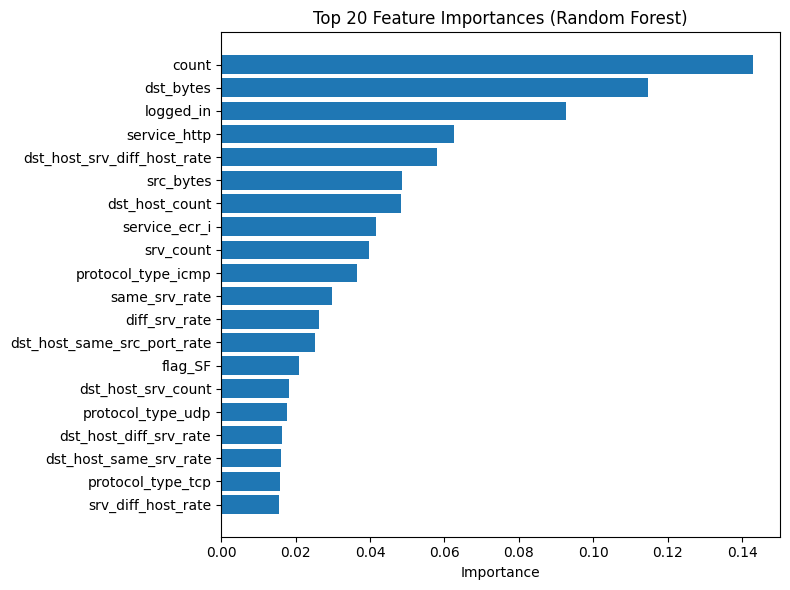

,threshold,precision,recall,f1
2,0.3,0.999875,0.999627,0.999751
3,0.4,0.999875,0.999378,0.999626
1,0.2,0.999254,0.999876,0.999564
4,0.5,1.000000,0.999004,0.999502
5,0.6,1.000000,0.998880,0.999440


In [72]:

# RF bulunursa önemleri çıkar
if "Random Forest" in best_models:
    best_rf = best_models["Random Forest"]
    ohe = best_rf.named_steps['prep'].named_transformers_['cat']
    cat_feature_names = list(ohe.get_feature_names_out(['protocol_type','service','flag']))
    num_feature_names = [c for c in df.columns if c not in ['protocol_type','service','flag','label','label_binary']]
    all_feature_names = cat_feature_names + num_feature_names

    rf = best_rf.named_steps['clf']
    importances = rf.feature_importances_
    feat_imp = pd.DataFrame({"feature": all_feature_names, "importance": importances})\
               .sort_values("importance", ascending=False).head(20)
    display(feat_imp)

    plt.figure()
    plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1])
    plt.xlabel("Importance"); plt.title("Top 20 Feature Importances (Random Forest)")
    plt.tight_layout(); plt.show()

    # Eşik Ayarı (RF)
    y_proba = best_rf.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 9)
    rows = []
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tp = ((y_pred == 1) & (y_test == 1)).sum()
        fp = ((y_pred == 1) & (y_test == 0)).sum()
        fn = ((y_pred == 0) & (y_test == 1)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        rows.append({"threshold": th, "precision": precision, "recall": recall, "f1": f1_score(y_test, y_pred)})
    th_df = pd.DataFrame(rows).sort_values("f1", ascending=False)
    display(th_df.head())



## VII. PCA(2D) Üzerinde Sınıf Karar Sınırları (SVM ile)

Sınıfları **X–Y düzleminde görmek** için, eğitim/test verisini pipeline sonrası dönüştürüp **PCA(2)** ile indiriyoruz; ardından bir **SVM** ile karar sınırını çiziyoruz.


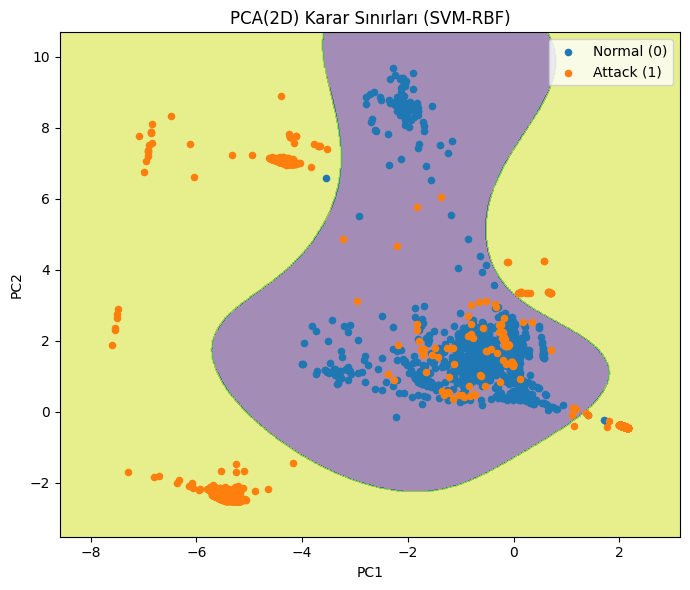

In [73]:

# Pipeline sonrası dönüştür
any_model = list(best_models.values())[0]
prep = any_model.named_steps['prep']
X_train_tr = prep.transform(X_train)
X_test_tr  = prep.transform(X_test)

# Dense'e çevir
X_train_dense = X_train_tr.toarray() if hasattr(X_train_tr, "toarray") else X_train_tr
X_test_dense  = X_test_tr.toarray() if hasattr(X_test_tr, "toarray") else X_test_tr

# PCA(2)
pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca_vis.fit_transform(X_train_dense)
X_test_2d  = pca_vis.transform(X_test_dense)

# Görsel sınırlayıcı model
svm_vis = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
svm_vis.fit(X_train_2d, y_train)

# Meshgrid
x1_min, x1_max = X_test_2d[:,0].min()-1, X_test_2d[:,0].max()+1
x2_min, x2_max = X_test_2d[:,1].min()-1, X_test_2d[:,1].max()+1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                       np.arange(x2_min, x2_max, 0.02))
Z = svm_vis.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx1, xx2, Z, alpha=0.5)
plt.scatter(X_test_2d[y_test==0,0], X_test_2d[y_test==0,1], s=20, label="Normal (0)")
plt.scatter(X_test_2d[y_test==1,0], X_test_2d[y_test==1,1], s=20, label="Attack (1)")
plt.title("PCA(2D) Karar Sınırları (SVM-RBF)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout(); plt.show()



## VIII. K-Means: Elbow ve Silhouette

Denetimsiz öğrenmeye örnek olarak (demo niteliğinde), pipeline sonrası dönüştürülmüş özellikler üzerinde **K-Means** için **Elbow (WCSS)** grafiği ve **Silhouette** skorunu hesaplıyoruz.


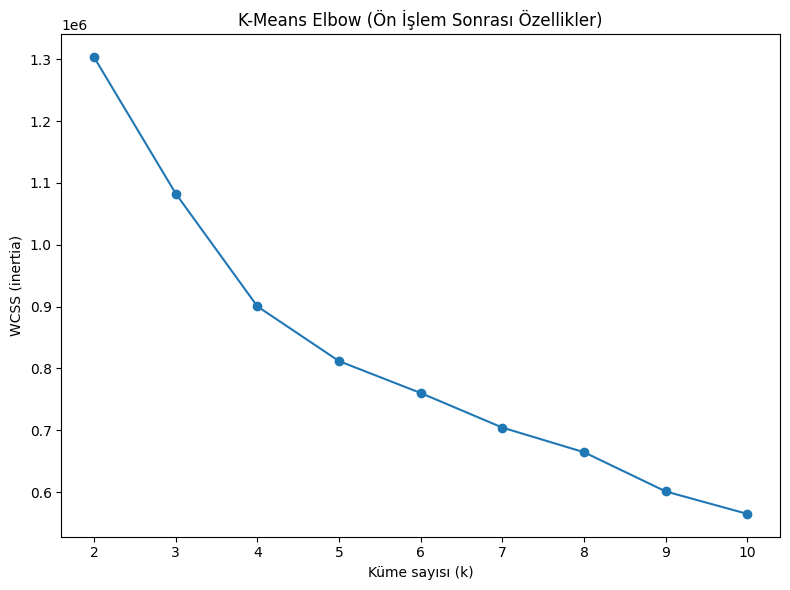

Silhouette skoru: 0.765


In [74]:

X_all = df[categorical_cols + numeric_cols]
X_all_tr = prep.transform(X_all)
X_all_dense = X_all_tr.toarray() if hasattr(X_all_tr, "toarray") else X_all_tr

# Elbow (WCSS)
wcss = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=RANDOM_STATE)
    km.fit(X_all_dense)
    wcss.append(km.inertia_)

plt.figure()
plt.plot(list(K), wcss, marker="o")
plt.title("K-Means Elbow (Ön İşlem Sonrası Özellikler)")
plt.xlabel("Küme sayısı (k)"); plt.ylabel("WCSS (inertia)")
plt.tight_layout(); plt.show()

# Örnek bir k için silhouette
k_best = 5  # elbow grafiğine göre güncelleyebilirsiniz
km_best = KMeans(n_clusters=k_best, init="k-means++", n_init=10, random_state=RANDOM_STATE)
labels = km_best.fit_predict(X_all_dense)
print("Silhouette skoru:", round(silhouette_score(X_all_dense, labels), 3))



## IX. SelectKBest (ANOVA F) ile Örnek Özellik Seçimi

Karma veri tiplerinde, yalnızca **sayısal** sütunlar üzerinde **ANOVA F (f_classif)** ile en iyi `k` özellik seçimi.


In [75]:

X_num = df[numeric_cols].copy()
y_bin = df["label_binary"].copy()

selector = SelectKBest(score_func=f_classif, k=10)  # en iyi 10 sayısal özellik
X_num_sel = selector.fit_transform(X_num, y_bin)
selected_num_features = np.array(numeric_cols)[selector.get_support()]
print("Seçilen sayısal özellikler:", selected_num_features)


Seçilen sayısal özellikler: ['logged_in' 'count' 'srv_count' 'serror_rate' 'srv_serror_rate'
 'same_srv_rate' 'srv_diff_host_rate' 'dst_host_count'
 'dst_host_same_src_port_rate' 'dst_host_srv_serror_rate']


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 5 11 16 17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Özellik seçimi aşamasında bazı sütunların (örneğin num_outbound_cmds) sabit değer aldığı ve bilgi taşımadığı gözlenmiştir. Bu sütunlar analizde elenmiş, kalan değişkenler arasında özellikle logged_in, srv_count, serror_rate gibi ağ trafiği metriklerinin anomalilerin ayırt edilmesinde kritik rol oynadığı görülmüştür.


## X. Modellerin Kaydedilmesi

En iyi modeller **joblib** ile diske kaydedilir.


In [76]:

os.makedirs("models", exist_ok=True)
for name, model in best_models.items():
    safe = name.lower().replace(" ", "_")
    joblib.dump(model, f"models/{safe}.joblib")
print("Modeller kaydedildi: models/ klasöründe.")


Modeller kaydedildi: models/ klasöründe.



## XI. Kapanış

Binary (Normal vs Attack) yaklaşımı ile dört farklı klasik algoritma (Logistic Regression, Random Forest, Decision Tree, SGD) GridSearchCV ile optimize edilerek karşılaştırıldı.

Random Forest modeli ROC-AUC (CV) = 1.0000 ile en yüksek başarıyı göstermiştir. Parametre ayarı (n_estimators=200, max_depth=None) ile veri setindeki saldırı ve normal trafiği neredeyse hatasız ayırt edebilmiştir.

Logistic Regression da ROC-AUC (CV) = 0.9997 ile çok yüksek performans sağlamış, bu da lineer sınırların bile bu veri setinde oldukça etkili olduğunu göstermektedir.

Decision Tree ROC-AUC (CV) = 0.9993 ile güçlü sonuçlar vermiş, özellikle class_weight='balanced' kullanımı dengesiz veri setinde faydalı olmuştur.

SGD (Linear) modeli ROC-AUC (CV) = 0.9994 ile oldukça başarılı sonuç üretmiştir. Bu, lineer ve hızlı algoritmaların bile doğru ön işleme ile yüksek başarı sağlayabileceğini göstermektedir.

Bu sonuçlar, KDD Cup 1999 veri setinin saldırı ve normal trafiği belirgin şekilde ayrıştırılabilir olduğunu ortaya koymaktadır. Gerçek dünyadaki karmaşık ve güncel veri setlerinde bu kadar yüksek performans beklenmemekle birlikte, klasik algoritmaların doğru ön işleme ve hiperparametre optimizasyonu ile güçlü performans gösterebileceği görülmüştür.

PCA(2) ile karar sınırı görselleştirme sunum açısından faydalı olmuş, sınıfların ayrışmasının görsel kanıtı sağlanmıştır.

K-Means ve SelectKBest ile denetimsiz öğrenme ve özellik seçimine dair kısa demolar eklenerek modelleme süreci desteklenmiştir.

Dengesiz veri durumlarında class_weight ve scale_pos_weight gibi yaklaşımların etkili olduğu görülmüştür.

Random Forest modeli hem eğitim hem test setinde ROC-AUC ve PR-AUC değerlerinde 1.0’a ulaşmış, F1 skoru da test setinde 0.9995 olmuştur.

Bu durum, modelin aşırı öğrenme yapmadığını, KDD Cup 1999 veri setinde saldırı ve normal trafiğin çok belirgin ayrıştığını göstermektedir. Gerçek dünyada bu kadar yüksek performans beklenmemekle birlikte, klasik literatürde de benzer şekilde %99–100 arası sonuçlar raporlanmıştır.